In [0]:
# https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub

In [0]:
import matplotlib.pylab as plt

import tensorflow as tf

In [0]:
#!pip install -q -U tf-hub-nightly
#!pip install -q tfds-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers

#### An ImageNet classifier
Download the classifier
Use hub.module to load a mobilenet, and tf.keras.layers.Lambda to wrap it up as a keras layer. Any TensorFlow 2 compatible image classifier URL from tfhub.dev will work here.

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" 

In [0]:
IMAGE_SHAPE = (224,224)
classifier = tf.keras.Sequential([
                                  hub.KerasLayer(classifier_url,input_shape=IMAGE_SHAPE+(3,))
])

Run it on a single image
Download a single image to try the model on.

65536/61306 [================================] - 0s 0us/step


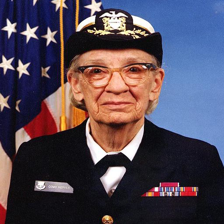

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [8]:
# Add a batch dimension, and pass the image to the model.
result = classifier.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

The result is a 1001 element vector of logits, rating the probability of each class for the image.

So the top class ID can be found with argmax:

In [9]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


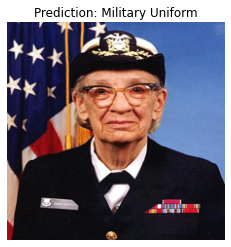

In [12]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

### Simple transfer learning
Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

Dataset<br>
For this example you will use the TensorFlow flowers dataset:

In [13]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [15]:
image_data = image_generator.flow_from_directory(str(data_root),target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [16]:
##The resulting object is an iterator that returns image_batch, label_batch pairs.
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break # to stop after one iteration

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [17]:
len(image_data)

115

In [18]:
# run classifier on batch of images
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [19]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['fountain', 'daisy', 'car mirror', 'hip', 'quill', 'cardoon',
       'bee', 'sea anemone', 'daisy', 'vase', 'picket fence', 'cliff',
       'sea urchin', 'cardoon', 'sea urchin', 'daisy', 'picket fence',
       'bee', 'snail', 'picket fence', 'bonnet', 'tractor', 'bee',
       'daisy', 'daisy', 'daisy', 'greenhouse', 'bee', 'paper towel',
       'daisy', 'porcupine', 'sea urchin'], dtype='<U30')

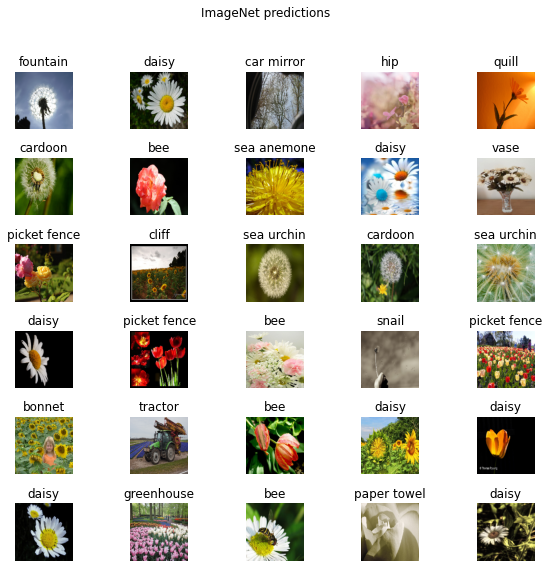

In [20]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

### Download the headless model
TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any Tensorflow 2 compatible image feature vector URL from tfhub.dev will work here.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

In [25]:
# It returns a 1280-length vector for each image:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [27]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
predictions = model(image_batch)
predictions.shape

TensorShape([32, 5])

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

Now use the .fit method to train the model.

To keep this example short train just 2 epochs. To visualize the training progress, use a custom callback to log the loss and accuracy of each batch individually, instead of the epoch average.

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [31]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 126s 1s/step - loss: 0.4547 - acc: 0.8125
Epoch 2/2
115/115 [==============================] - 126s 1s/step - loss: 0.3050 - acc: 0.8750


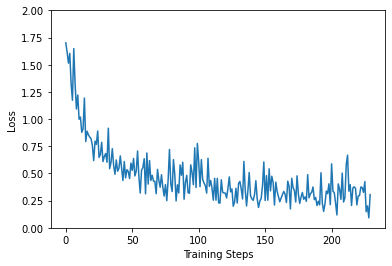

In [32]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

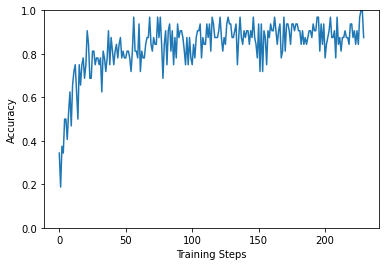

In [33]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [34]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')